In [141]:
# Импортируем библиотеки и модули
import pandas as pd  
from sklearn.model_selection import train_test_split # Загружаем специальный инструмент для разбивки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import SelectKBest
from collections import Counter
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt

# <center>1. Знакомство с данными<center>

In [142]:
# Загружаем данные
hotels = pd.read_csv('C:\IDE\data\Project-3\hotels.csv')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [143]:
# Выводим количество пропущенных значений в столбцах
colls_null_percent = hotels.isnull().mean()*100
colls_with_null = colls_null_percent[colls_null_percent>0].sort_values(ascending=False)
display(colls_with_null)

lat    0.63288
lng    0.63288
dtype: float64

In [144]:
# Выводим информацию о таблице
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

# <center>2. Подготовка данных<center>

In [145]:
# Выводим информацию о числе уникальных названий отелей(количество самих отелей в данных)
display(len(hotels['hotel_name'].unique()))

1492

In [146]:
# Преобразуем дату в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'], yearfirst=True)

# Выводим дату самого раннего и самого свежего отзыва
print(hotels['review_date'].min())
print(hotels['review_date'].max())

2015-08-04 00:00:00
2017-08-03 00:00:00


In [147]:
# Заменяем элементы в строке признака
replace_1 = lambda x: x.replace('[', '')
hotels['tags']= hotels['tags'].apply(replace_1)

replace_2 = lambda x: x.replace(']', '')
hotels['tags']= hotels['tags'].apply(replace_2)

# делим строку признака на список отдельных тегов
separate_func = lambda x: x.split(', ')
hotels['tags']= hotels['tags'].apply(separate_func)

In [148]:
# Создаем функцию для подсчета уникальных значений тегов
def unique_tags(column):
    """Функция для создания списка уникальных тегов

    Args:
        column (object): На вход подаеться признак с тегами, оставленными постояльцами отеля

    Returns:
        list: Список уникальных значений тегов
    """
    tags_list = list()
    
    for elem in column:
        for i in elem:
            if i not in tags_list:
                tags_list.append(i)
                
    return tags_list
print(len(unique_tags(hotels['tags'])))

2368


In [149]:
# Находим самый популярный тэг
def all_tags(column):
    """Функция для создания списка всех тегов

    Args:
        column (object): На вход подается признак с тегами, оставленными постояльцами отеля

    Returns:
        list: Список всех тегов
    """
    tags_list = list()
    
    for elem in column:
        for i in elem:
            tags_list.append(i)
            
    return tags_list
# Используем обьект Counter для подсчета количества каждого тега
c = Counter(all_tags(hotels['tags']))  
print(c)      

Counter({"' Leisure trip '": 313593, "' Submitted from a mobile device '": 230778, "' Couple '": 189212, "' Stayed 1 night '": 145373, "' Stayed 2 nights '": 100263, "' Solo traveler '": 81235, "' Stayed 3 nights '": 72000, "' Business trip '": 61989, "' Group '": 49088, "' Family with young children '": 45836, "' Stayed 4 nights '": 35748, "' Double Room '": 26386, "' Standard Double Room '": 24151, "' Superior Double Room '": 23550, "' Family with older children '": 19802, "' Deluxe Double Room '": 18623, "' Double or Twin Room '": 16824, "' Stayed 5 nights '": 15611, "' Standard Double or Twin Room '": 13062, "' Classic Double Room '": 12716, "' Superior Double or Twin Room '": 10238, "' 2 rooms '": 9287, "' Stayed 6 nights '": 7399, "' Standard Twin Room '": 7325, "' Single Room '": 7227, "' Twin Room '": 6279, "' Stayed 7 nights '": 5549, "' Executive Double Room '": 4763, "' Classic Double or Twin Room '": 4576, "' Superior Twin Room '": 4540, "' Club Double Room '": 4485, "' Del

In [150]:
# Находим на сколько всего ночей, чаще всего, останавливаются потушественники в отелях
def night_stay(column):
    """Функция для создания списка тегов с количеством ночей, на которые останавливались постояльцы

    Args:
        column (object): На вход подаеться признак с тегами, оставленными постояльцами отеля

    Returns:
        list: Список с тегами о количестве ночей. проведенных в отеле постояльцами
    """
    night_stay_list = list()
    
    for elem in column:
        for i in elem:
            if 'Stayed' in i:
                night_stay_list.append(i)
                
    return night_stay_list
# Используем обьект Counter для подсчета каждого тега в списке
a = Counter(night_stay(hotels['tags']))
print(a)             

Counter({"' Stayed 1 night '": 145373, "' Stayed 2 nights '": 100263, "' Stayed 3 nights '": 72000, "' Stayed 4 nights '": 35748, "' Stayed 5 nights '": 15611, "' Stayed 6 nights '": 7399, "' Stayed 7 nights '": 5549, "' Stayed 8 nights '": 1910, "' Stayed 9 nights '": 966, "' Stayed 10 nights '": 663, "' Stayed 11 nights '": 306, "' Stayed 12 nights '": 217, "' Stayed 14 nights '": 184, "' Stayed 13 nights '": 174, "' Stayed 15 nights '": 87, "' Stayed 16 nights '": 38, "' Stayed 17 nights '": 27, "' Stayed 18 nights '": 24, "' Stayed 19 nights '": 23, "' Stayed 21 nights '": 19, "' Stayed 20 nights '": 17, "' Stayed 27 nights '": 10, "' Stayed 30 nights '": 10, "' Stayed 22 nights '": 8, "' Stayed 28 nights '": 7, "' Stayed 26 nights '": 6, "' Stayed 23 nights '": 6, "' Stayed 24 nights '": 5, "' Stayed 25 nights '": 4, "' Stayed 29 nights '": 3})


# <center>3. Преобразование признаков<center>

### *3.1 Работа с признаком hotel_address. Создадим новый признак - страна отеля*

In [151]:
# Для начала найдем в каких странах находятся отели и заодно посмотрим количество отзывов для каждой страны
def address_hotel(column):
    """Функция для создания списка стран в которых распологаются отели

    Args:
        column (object): На вход подается признак с адресом отеля

    Returns:
        list: Список всех стран, в которых находятся отели
    """
    address_list = list()
    for elem in column:
        elem = elem.split(' ')
        elem = elem[-2:]
        
        if 'United' in elem:
           elem = elem[0] + ' ' + elem[1]
           address_list.append(elem)
        else:
            address_list.append(elem[-1])
               
    return address_list
# С помощью обьекта Counter смотрим на уникальные значения стран и количество отзывов об отелях 
b = Counter(address_hotel(hotels['hotel_address']))
print(b)  

# Создадим функцию для признака страны
def hotel_country(column):
    """Функция для создания признака страны

    Args:
        column (object): На вход подается признак с адресом отеля

    Returns:
        str: Строка с названием страны, где расположен отель
    """
    column_splited = column.split(' ')[-2:]
    if 'United' in column_splited:
       return column_splited[0] + ' ' + column_splited[1]
    else:
       return column_splited[-1]  
             
# Создаем новый признак, применяя функцию к признаку адреса отеля   
hotels['hotel_country'] = hotels['hotel_address'].apply(hotel_country)
# Удаляем признак с адрессом отеля, так он содержит слишком много уникальных значений 
hotels = hotels.drop(['hotel_address'], axis=1)

Counter({'United Kingdom': 196774, 'Spain': 45132, 'France': 44830, 'Netherlands': 43006, 'Austria': 29178, 'Italy': 27883})


### *3.2 Работа с признаком review_date. Создадим два целочисленных признака: Год и Месяц.*

In [152]:
# Создаем признак года
hotels['review_year'] = hotels['review_date'].dt.year
# Создаем признак месяца
hotels['review_month'] = hotels['review_date'].dt.month

# Удаляем старый признак даты
hotels = hotels.drop(['review_date'], axis=1)

### *3.3 Работа с признаком days_since_review. Приведем признак к числовому формату*

In [153]:
# Функция для преобразования признака
def days_since_review_to_int(column):
    """Функция возвращает целочисленное значение признака

    Args:
        column (object): На вход подается признак с строковым значением дней с момента оценки отеля

    Returns:
        _int_: Возвращает число дней с момента оценки отеля в числовом формате
    """
    column_splited = column.split(' ')
    return int(column_splited[0]) 

# Применяем функцию к исходному признаку
hotels['days_since_review_int'] = hotels['days_since_review'].apply(days_since_review_to_int)

# Удаляем старый признак
hotels = hotels.drop(['days_since_review'], axis=1) 

### *3.4 Работа с признаками negative_review и positive_review*

In [154]:
# Посмотрим на количество уникальных значений в данных двух признаках
print(len(hotels['negative_review'].unique()))
print(len(hotels['positive_review'].unique()))

248828
311737


In [155]:
# Количество уникальных значений слишком велико. Это может негативно сказаться на моделе. Попробуем удалить их из Data Frame
hotels = hotels.drop(['negative_review', 'positive_review'], axis=1)

### *3.5 Создадим новый признак night_stayed* 

In [156]:
def night_stayed(column):
    """Функция создает целочисленный признак количества ночей проведенных в постояльцами в отеле

    Args:
        column (object): На вход подаеться признак с тегами, оставленными постояльцами отеля

    Returns:
        _int_: Числовое значение количества ночей проведенных в отеле
    """
    
    for elem in column:
        if 'Stayed' in elem:
            return int(elem.split(' ')[2])

# Применяем функцию к исходному признаку              
hotels['night_stayed'] = hotels['tags'].apply(night_stayed)            

In [157]:
colls_null_percent = hotels.isnull().mean()*100
colls_with_null = colls_null_percent[colls_null_percent>0].sort_values(ascending=False)
display(colls_with_null)

lat             0.632880
lng             0.632880
night_stayed    0.037745
dtype: float64

In [158]:
hotels['night_stayed'] = hotels['night_stayed'].fillna(hotels['night_stayed'].min())

In [159]:
colls_null_percent = hotels.isnull().mean()*100
colls_with_null = colls_null_percent[colls_null_percent>0].sort_values(ascending=False)
display(colls_with_null)

lat    0.63288
lng    0.63288
dtype: float64

# <center>4.Кодирование признаков<center>
### *4.1 Работа с признаком hotel_name*

In [160]:
# Создаем список 10 самых популярных отелей
top_values_list = list(hotels['hotel_name'].value_counts().head(10).keys()) 

# Создаем функцию для отсеивания значений признака
def popular_values(column):
    """Функция принимает на вход признак, и возвращает только необходимые нам значения. Для остальных оставляет значение other

    Args:
        column (object): Признак с названиями отеля

    Returns:
        object: Возвращает откорректированный признак
    """
    if column in top_values_list:
        return column
    else:
        return 'other'
# Применяем функцию к нужному нам признаку    
hotels['hotel_name'] = hotels['hotel_name'].apply(popular_values)  

# Кодируем признак методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
hotels_name_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, hotels_name_bin],axis=1)

### *4.2 Работа с признаком reviewer_nationality*

In [161]:
# Создаем список 10 самых часто встречающихся национальностей постояльцев
top_values_list = list(hotels['reviewer_nationality'].value_counts().head(10).keys())
# Применяем ранее созданную функцию popular_values к нужному нам признаку
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(popular_values)

# Кодируем признак методом бинарного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
reviewer_nationality_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, reviewer_nationality_bin], axis=1)

### *4.3 Работа с признаком tags*

In [162]:
# Задаем список 10 самых популярных тегов
top_values_list = list(dict(c.most_common(10)).keys())

# Создаем функцию для определения популярного тега в признаке
def top_tags(column):
    """Функция принимет на вход признак и возвращает 1 если в элементе признака присутсвует хотя бы один из популярных тегов.
    В обратном случае возвращает 0.

    Args:
        column (object): Признак с тегами постояльцев.

    Returns:
        _int_: Возвращает числовое значение в зависимости от вхождения тега в список
    """
    for elem in column:
       if elem in top_values_list:
           return 1
       else:
           return 0
# Применяем функцию к нужному признаку       
hotels['tags'] = hotels['tags'].apply(top_tags)   

### *4.4 Работа с признаком hotel_country*

In [164]:
# Применим к признаку метод Однократного кодирования
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True)
type_bin = encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [165]:
# Удалим исходные признаки из Data Frame
hotels = hotels.drop(['hotel_country', 'hotel_name', 'reviewer_nationality'], axis=1)
# Удаляем признаки долготы и широты
hotels = hotels.drop(['lat', 'lng'], axis=1)

In [166]:
display(hotels.head())

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,review_year,review_month,...,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain
0,581,8.4,3,1994,4,7,10.0,1,2016,2,...,0,0,0,1,1,0,0,0,0,0
1,299,8.3,3,1361,2,14,6.3,1,2017,1,...,0,0,0,1,1,0,0,0,0,0
2,32,8.9,6,406,0,14,7.5,1,2016,10,...,0,0,1,0,0,1,0,0,0,0
3,34,7.5,0,607,11,8,10.0,1,2015,9,...,0,0,0,1,0,1,0,0,0,0
4,914,8.5,4,7586,20,10,9.6,1,2016,3,...,0,0,1,0,0,0,1,0,0,0


In [167]:
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   tags                                        386803 non-null  int64  
 8   review_year                                 386803 non-null  int32  
 9   review_month                                386803 non-null  int32  
 

None

# <center>5.Создание модели<center>

<Axes: >

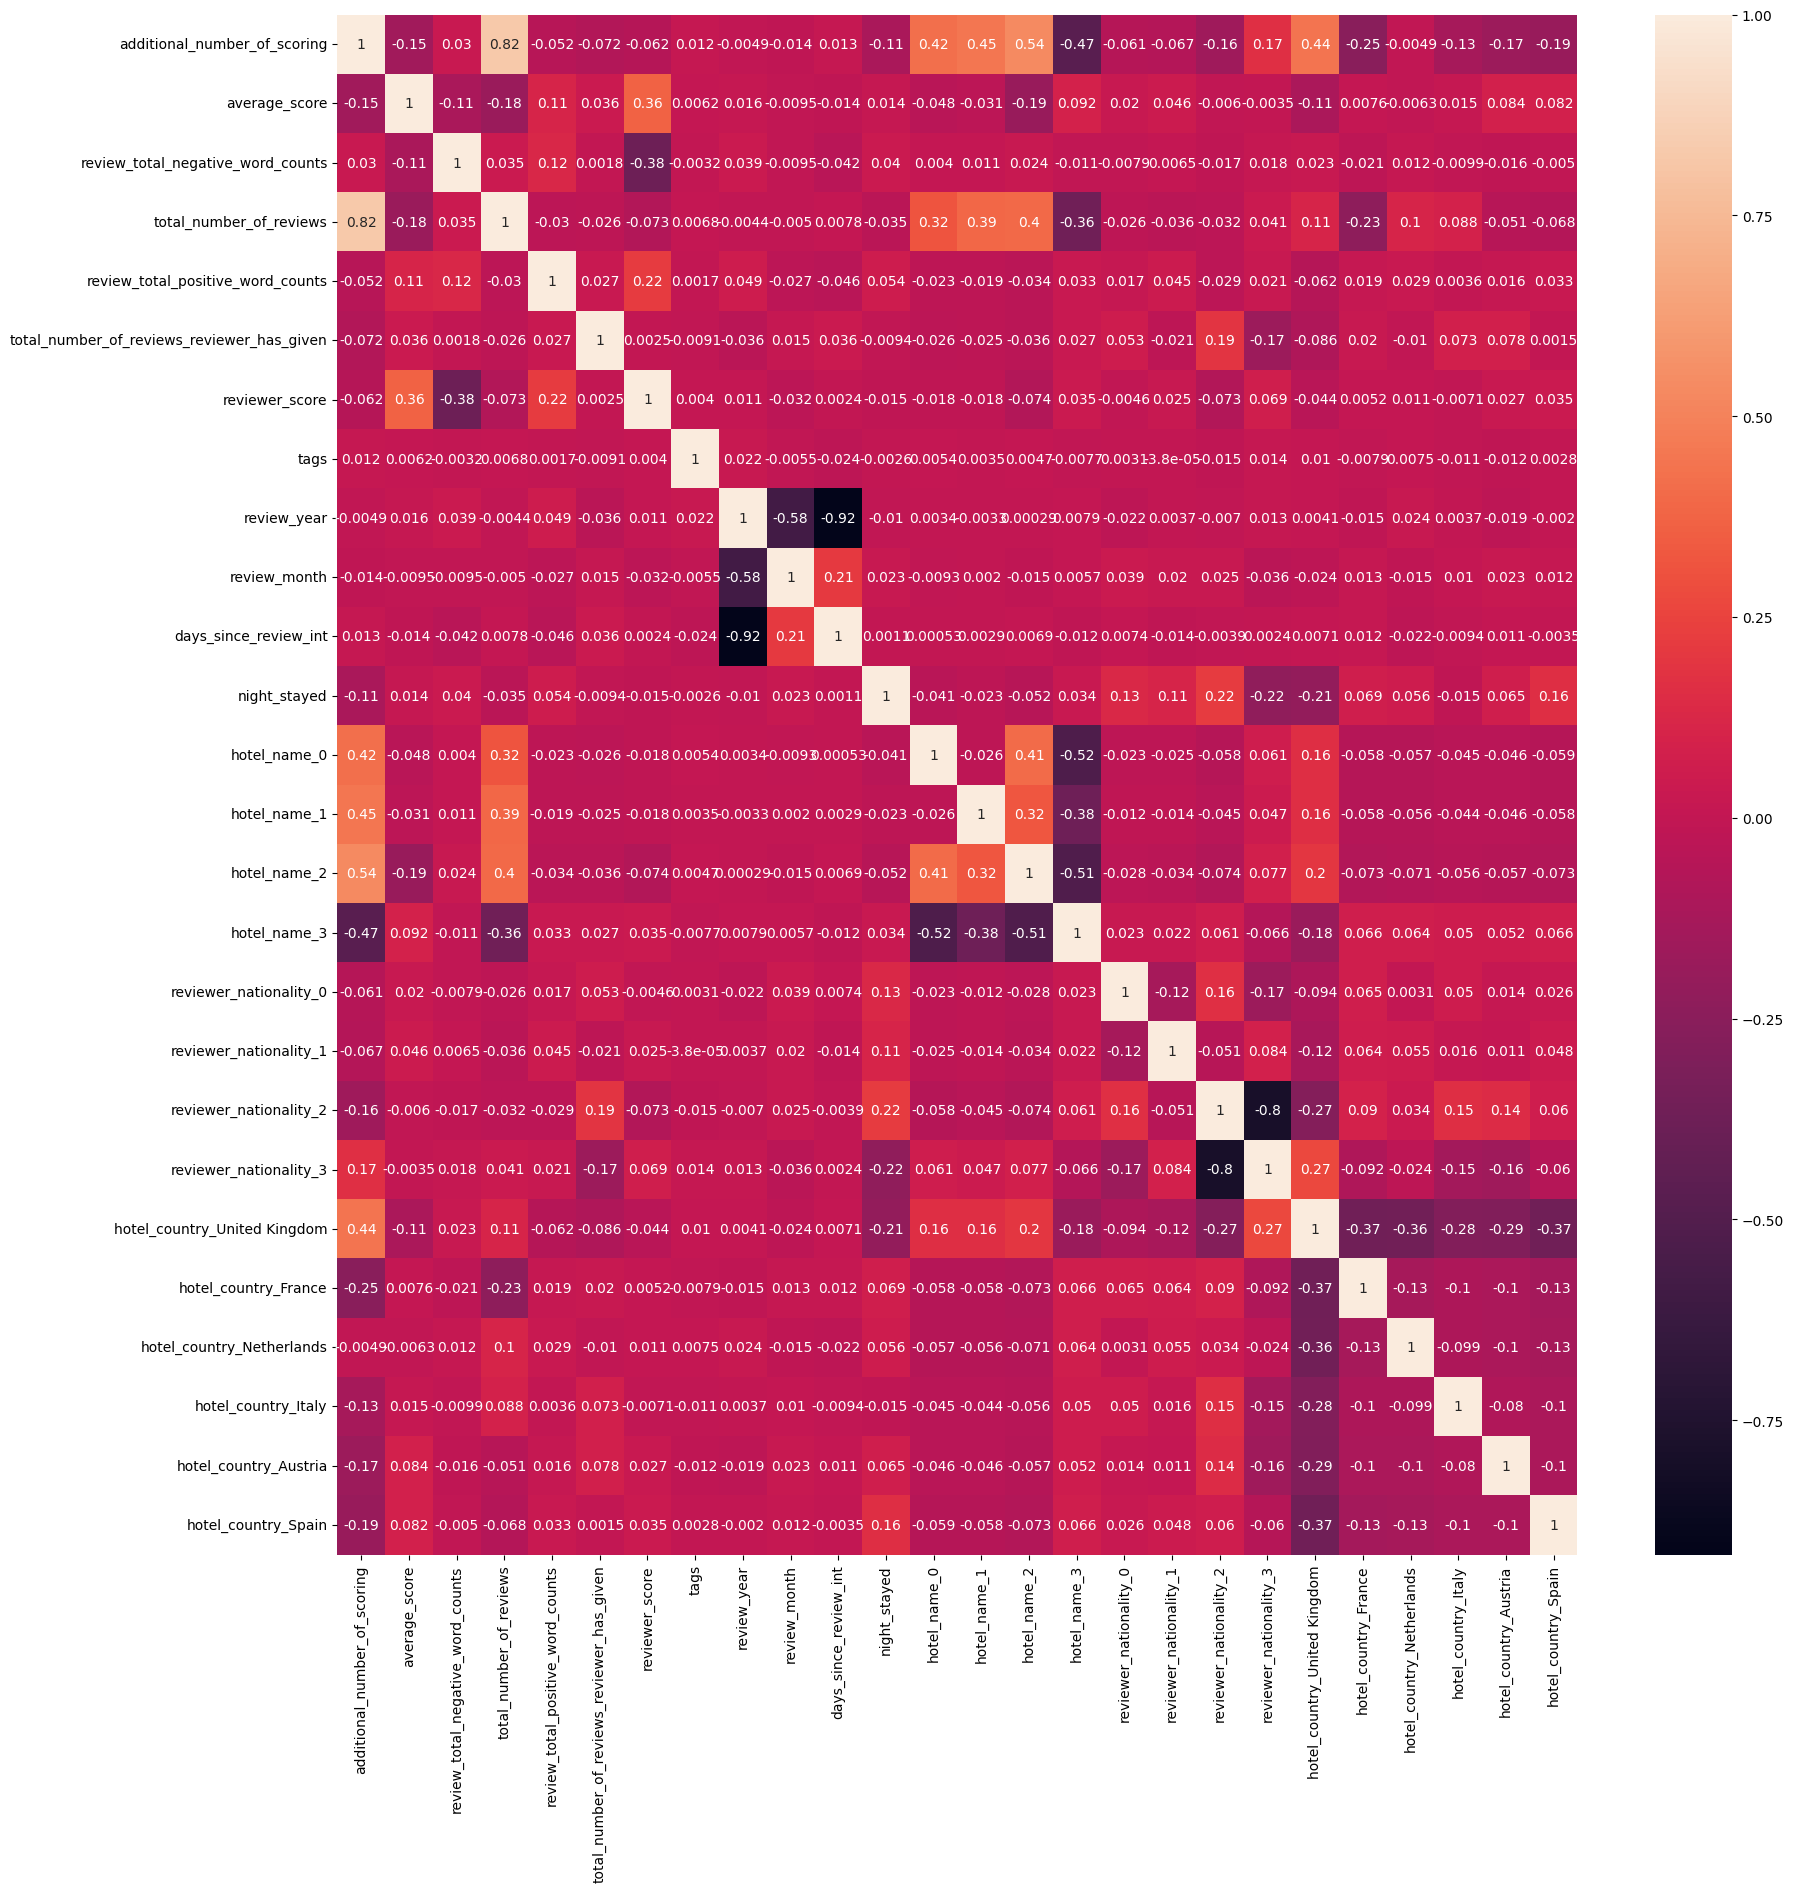

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(hotels.corr(numeric_only=True), annot=True)

In [188]:
# Непрерывные признаки
num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'night_stayed', 'days_since_review_int']

# Категориальные признаки
cat_cols = ['average_score', 'tags', 'review_month', 'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'hotel_name_3', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands', 'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain', 'review_year']

In [182]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

<Axes: >

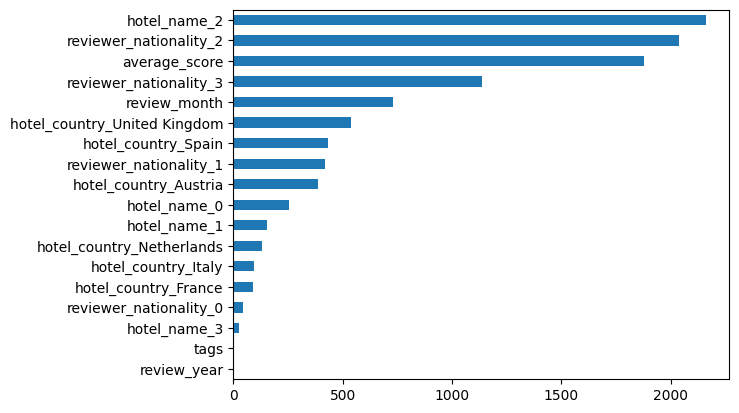

In [189]:
y = y.astype('int')
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<Axes: >

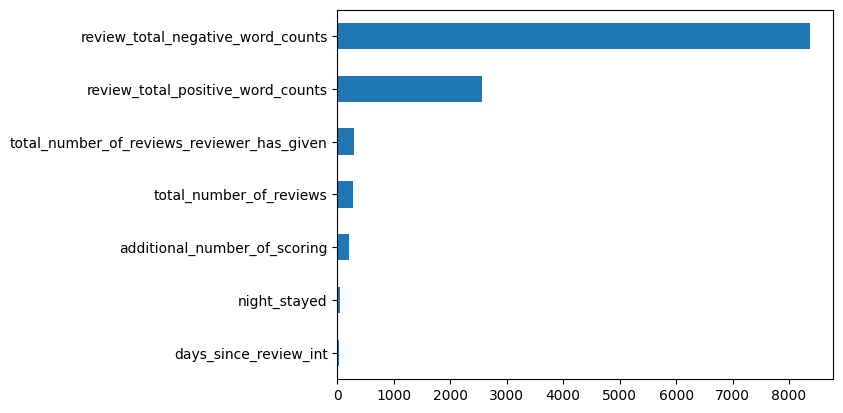

In [184]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [191]:
hotels = hotels.drop(['review_year', 'night_stayed', 'days_since_review_int', 'tags', 'hotel_name_3', 'reviewer_nationality_0'], axis=1)

In [192]:
# Непрерывные признаки
num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

# Категориальные признаки
cat_cols = ['average_score', 'review_month', 'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands', 'hotel_country_Italy', 'hotel_country_Austria', 'hotel_country_Spain']

In [193]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

<Axes: >

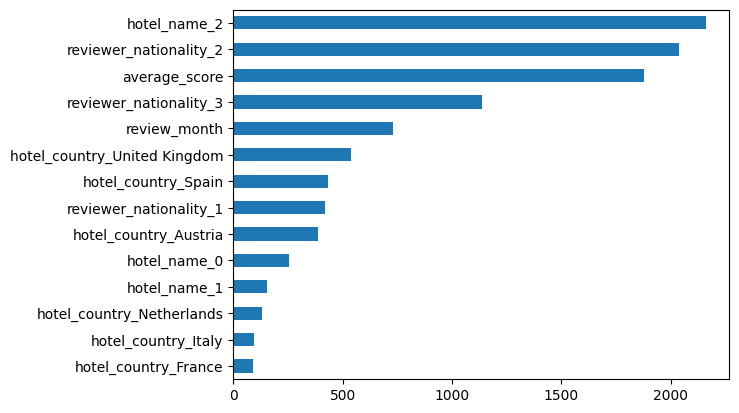

In [194]:
y = y.astype('int')
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<Axes: >

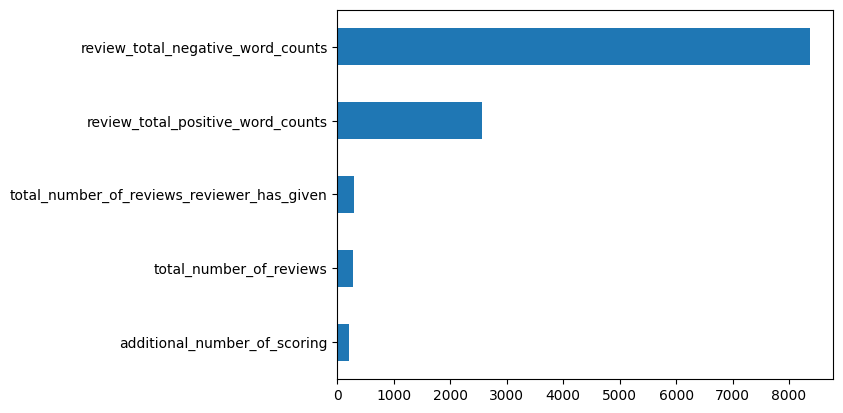

In [195]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [196]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [197]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [198]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.16275764818632035
